In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from trainer import run
from models import LogisticRegressionModel, LinearRegressionModel
from datasets import generate_boltzmann_classification_data, generate_classification_data, generate_1d_regression_data

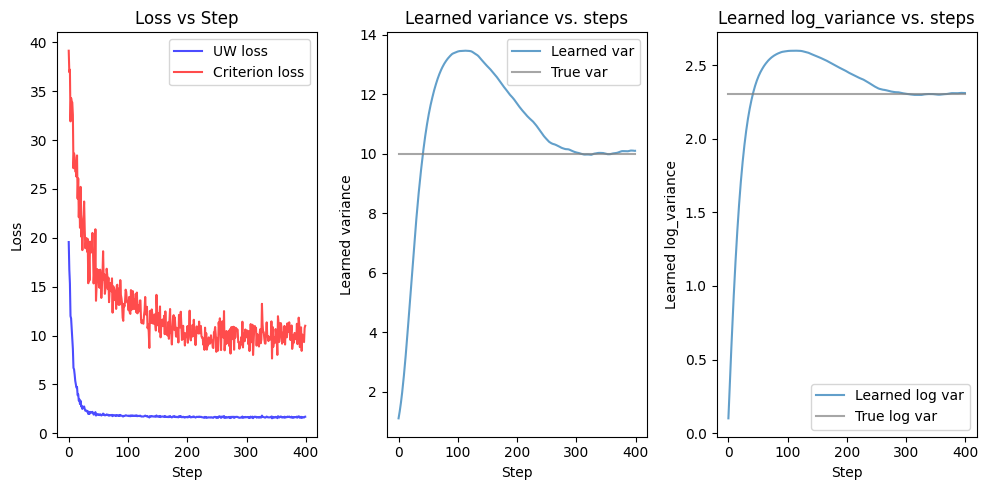

In [2]:
sample_vars = run(
    variance=10.0,
    data_generator=generate_1d_regression_data,
    model_class=LinearRegressionModel,
    epochs=1,
    batch_size=256,
    n_samples=400*256,
    lr=1e-1,
    repeats=1,
    device=torch.device('cuda'),
    uncertainty_weighing=True,
    plot_dynamics=True
)

MAE = 0.020401487307677168


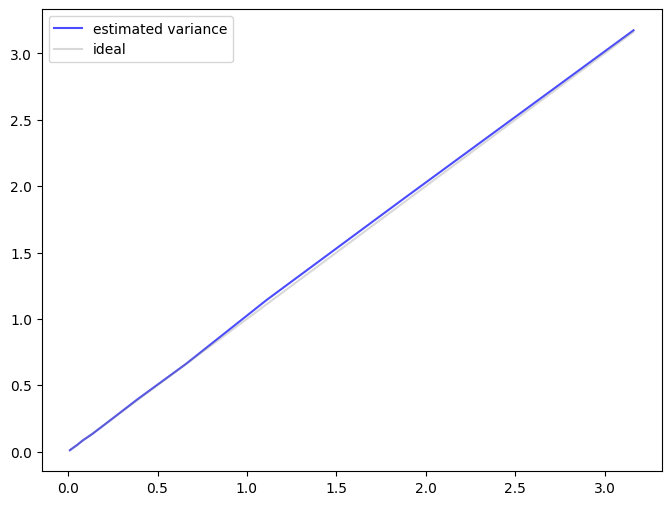

In [5]:
LR = (1e-1, 1e-1)
REPEATS = 3
BATCH_SIZE = 256

true_vars = np.logspace(-2.0, 0.5, 12)
learned_vars = np.zeros_like(true_vars)

for j, variance in enumerate(true_vars):

    sample_vars = run(
        variance=variance,
        data_generator=generate_1d_regression_data,
        model_class=LinearRegressionModel,
        epochs=1,
        batch_size=BATCH_SIZE,
        n_samples=2000*BATCH_SIZE,
        lr=LR,
        repeats=REPEATS,
        uncertainty_weighing=True
    )

    learned_vars[j] = np.mean(sample_vars)

plt.figure(figsize=(8, 6))
plt.plot(true_vars, learned_vars, color='blue', alpha=0.7, label=f'estimated variance')
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
plt.legend()
plt.show()

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


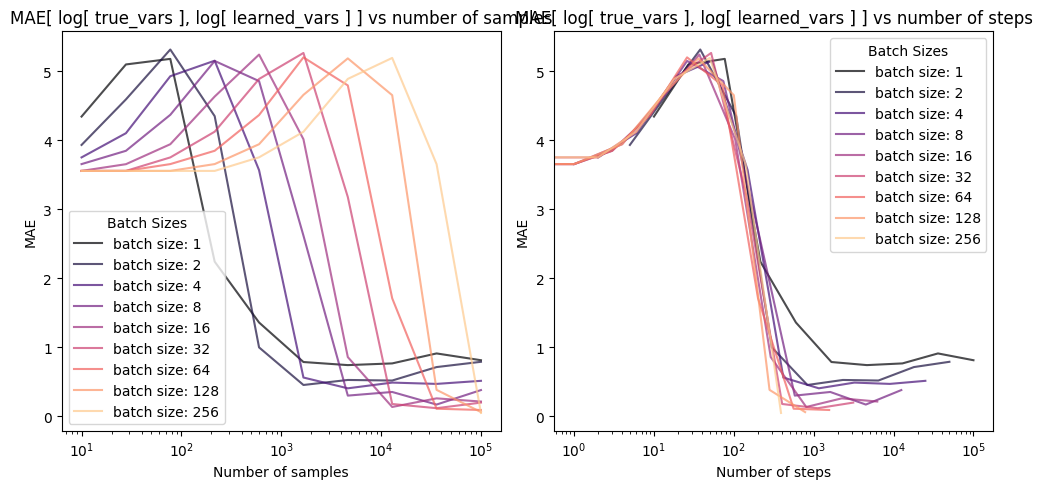

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import torch

LR = (1e-1, 1e-1)
REPEATS = 1
true_vars = np.logspace(-3, 0, 10)
num_samples = np.logspace(1, 5, 10)

batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
gofs = np.zeros(shape=[len(batch_sizes), len(num_samples)])

for k, batch_size in enumerate(batch_sizes):

    print(f"{k + 1} / {len(batch_sizes)}")
    for i, samples in enumerate(num_samples):

        learned_vars = np.zeros_like(true_vars)

        for j, variance in enumerate(true_vars):

            sample_vars = run(variance,
                              data_generator=generate_1d_regression_data,
                              model_class=LinearRegressionModel,
                              epochs=1,
                              lr=LR,
                              repeats=REPEATS,
                              n_samples=int(samples),
                              batch_size=batch_size,
                              uncertainty_weighing=True)

            learned_vars[j] = np.mean(sample_vars)
        
        gofs[k][i] = mae(np.log(true_vars), np.log(learned_vars))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

cmap = plt.get_cmap("magma")
colors = [cmap(i / len(batch_sizes)) for i in range(len(batch_sizes))]
for k, batch_size in enumerate(batch_sizes):
    plt.plot(num_samples, gofs[k], color=colors[k], alpha=0.7, label=f'batch size: {batch_size}')

plt.legend(title='Batch Sizes')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of samples')
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.xscale('log')

plt.subplot(1, 2, 2)
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(batch_sizes)) for i in range(len(batch_sizes))]
for k, batch_size in enumerate(batch_sizes):
    num_steps = num_samples // batch_size
    plt.plot(num_steps, gofs[k], color=colors[k], alpha=0.7, label=f'batch size: {batch_size}')

plt.legend(title='Batch Sizes')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of steps')
plt.xlabel('Number of steps')
plt.ylabel('MAE')
plt.xscale('log')

plt.tight_layout()
plt.show()

1 / 10


2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


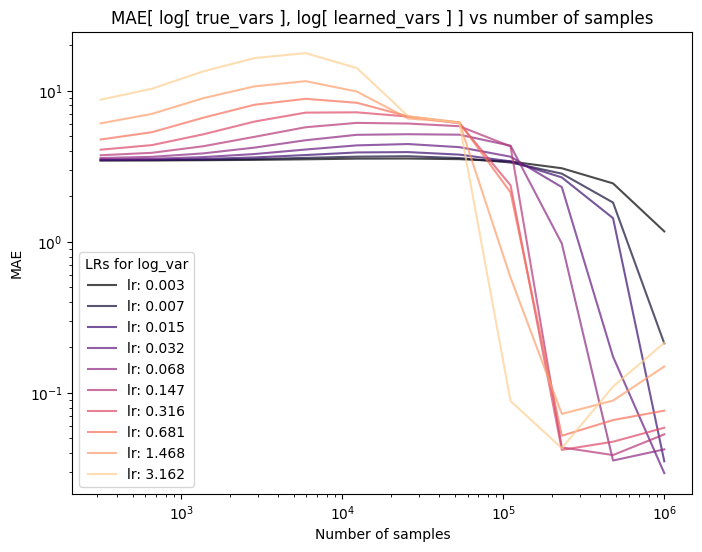

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import torch

REPEATS = 3
BATCH_SIZE = 256
true_vars   = np.logspace(-3, 0, 10)
num_samples = np.logspace(2.5, 6, 12)
uw_lrs      = np.logspace(-2.5, 0.5, 10)

gofs = np.zeros(shape=[len(uw_lrs), len(num_samples)])

for k, uw_lr in enumerate(uw_lrs):
    
    print(f"{k + 1} / {len(uw_lrs)}")
    for i, samples in enumerate(num_samples):

        learned_vars = np.zeros_like(true_vars)

        for j, variance in enumerate(true_vars):

            sample_vars = run(variance,
                              data_generator=generate_1d_regression_data,
                              model_class=LinearRegressionModel,
                              epochs=1,
                              lr=(1e-1, uw_lr),
                              repeats=REPEATS,
                              n_samples=int(samples),
                              batch_size=BATCH_SIZE,
                              uncertainty_weighing=True)

            learned_vars[j] = np.mean(sample_vars)
        
        gofs[k][i] = mae(np.log(true_vars), np.log(learned_vars))

plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(uw_lrs)) for i in range(len(uw_lrs))]
for k, uw_lr in enumerate(uw_lrs):
    plt.plot(num_samples, gofs[k], color=colors[k], alpha=0.7, label=f'lr: {uw_lr:.3f}')

plt.legend(title='LRs for log_var')
plt.title('MAE[ log[ true_vars ], log[ learned_vars ] ] vs number of samples')
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.xscale('log')
plt.yscale('log')
plt.show()

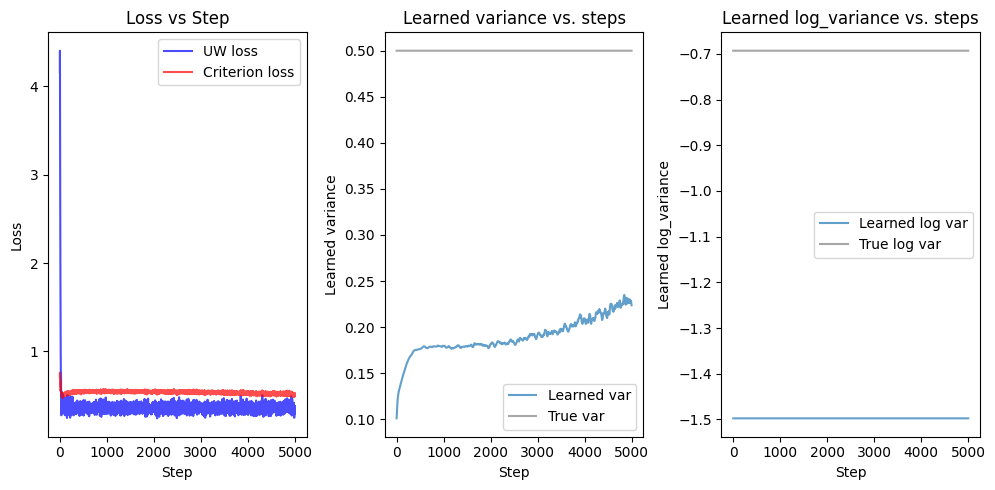

In [8]:
from functools import partial

n_features = 1

sample_vars = run(variance=0.5,
                  data_generator=partial(generate_classification_data, n_features=n_features, one_hot=False),
                  model_class=partial(LogisticRegressionModel, n_features=n_features, init_var_value=0.1, exact=True),
                  epochs=1,
                  batch_size=256,
                  n_samples=5000*256,
                  lr=1e-2,
                  repeats=1,
                  uncertainty_weighing=True,
                  plot_dynamics=True)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


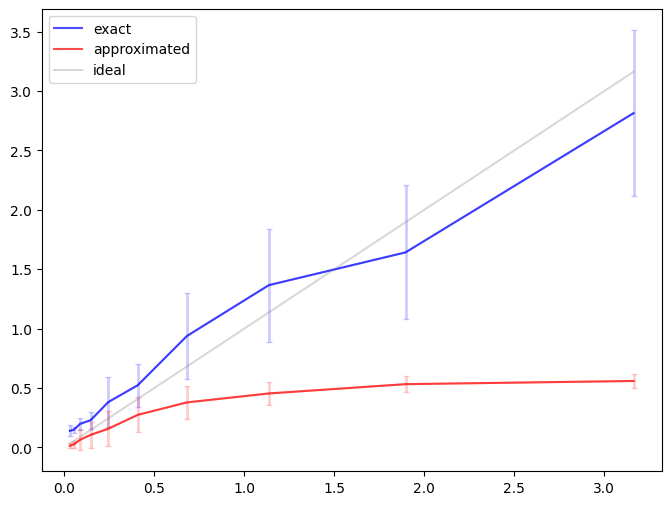

In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from functools import partial

LR = 1e-2
REPEATS = 3
SAMPLES = 2000
N_FEATURES = 1
BATCH_SIZE = 1
true_vars = np.logspace(-1.5, 0.5, 10)
learned_vars_exact = np.zeros_like(true_vars)
learned_vars_approx = np.zeros_like(true_vars)
stds = np.zeros(shape=(2, len(true_vars)))
device = torch.device('cuda' if batch_size > 64 else 'cpu') 

for j, variance in enumerate(true_vars):
    fn = partial(run,
                 variance=variance,
                 data_generator=partial(generate_classification_data, n_features=N_FEATURES, one_hot=False),
                 epochs=1,
                 batch_size=BATCH_SIZE,
                 n_samples=SAMPLES*BATCH_SIZE,
                 lr=LR,
                 repeats=REPEATS,
                 uncertainty_weighing=True)

    sample_vars = fn(model_class=partial(LogisticRegressionModel, n_features=N_FEATURES, exact=True))
    learned_vars_exact[j] = np.mean(sample_vars)
    stds[0][j] = np.std(sample_vars)

    sample_vars = fn(model_class=partial(LogisticRegressionModel, n_features=N_FEATURES, exact=False))
    learned_vars_approx[j] = np.mean(sample_vars)
    stds[1][j] = np.std(sample_vars)


plt.figure(figsize=(8, 6))
plt.plot(true_vars, learned_vars_exact, color='blue', alpha=0.7, label=f'exact')
plt.errorbar(true_vars, learned_vars_exact, yerr=stds[0], color='blue', elinewidth=2, capsize=2, alpha=0.2)
plt.plot(true_vars, learned_vars_approx, color='red', alpha=0.7, label=f'approximated')
plt.errorbar(true_vars, learned_vars_approx, yerr=stds[1], color='red', elinewidth=2, capsize=2, alpha=0.2)
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
plt.legend()
plt.show()

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15


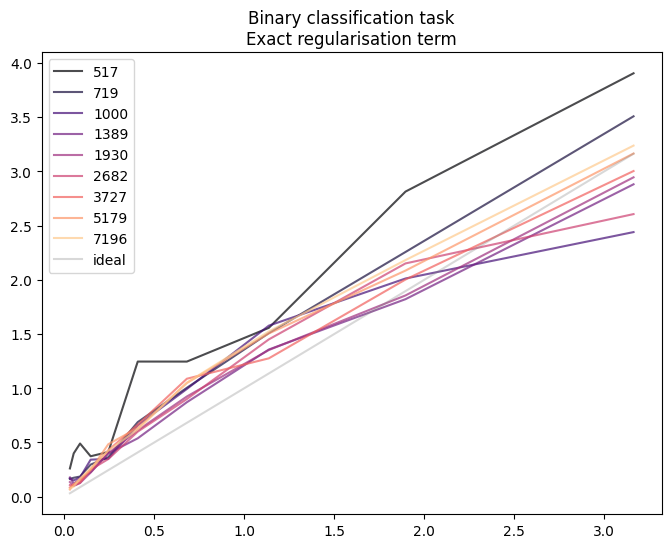

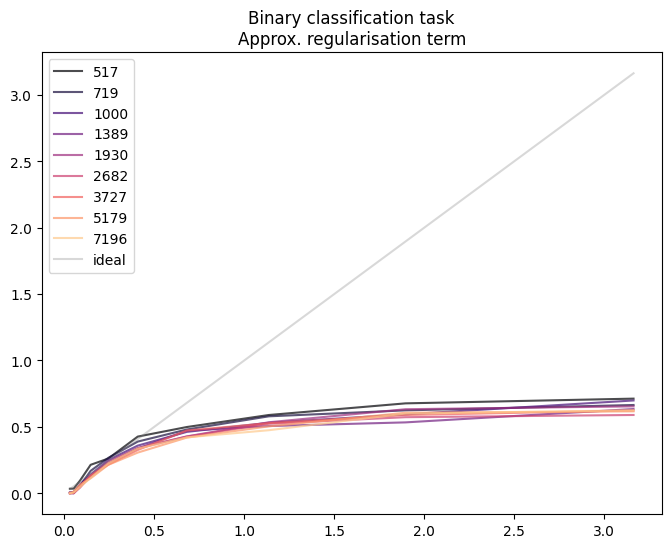

In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from functools import partial

LR = 1e-2
REPEATS = 3
N_FEATURES = 1
BATCH_SIZE = 1

true_vars = np.logspace(-1.5, 0.5, 10)
device = torch.device('cuda' if batch_size > 64 else 'cpu') 

num_samples = np.logspace(2, 4, 15)
learned_vars_exact = np.zeros(shape=(len(num_samples), len(true_vars)))
learned_vars_approx = np.zeros(shape=(len(num_samples), len(true_vars)))

for i, samples in enumerate(num_samples):
    for j, variance in enumerate(true_vars):
        
        fn = partial(run,
                     variance=variance,
                     data_generator=partial(generate_classification_data, n_features=N_FEATURES, one_hot=False),
                     epochs=1,
                     batch_size=BATCH_SIZE,
                     n_samples=int(samples)*BATCH_SIZE,
                     lr=LR,
                     repeats=REPEATS,
                     uncertainty_weighing=True)

        sample_vars = fn(model_class=partial(LogisticRegressionModel, n_features=N_FEATURES, exact=True))
        learned_vars_exact[i][j] = np.mean(sample_vars)

        sample_vars = fn(model_class=partial(LogisticRegressionModel, n_features=N_FEATURES, exact=False))
        learned_vars_approx[i][j] = np.mean(sample_vars)

subselect = (5,-1)

xs = num_samples[subselect[0]:subselect[1]]
y_exact = learned_vars_exact[subselect[0]:subselect[1],:]
y_approx = learned_vars_approx[subselect[0]:subselect[1],:]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

cmap = plt.get_cmap("magma")
colors = [cmap(i / len(xs)) for i in range(len(xs))]
for i, n_samples in enumerate(xs):
    plt.plot(true_vars, y_exact[i], color=colors[i], alpha=0.7, label=f'{int(n_samples)}')
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
plt.title('Binary classification task\nExact regularisation term')
plt.legend()

plt.subplot(1, 2, 2)
cmap = plt.get_cmap("magma")
colors = [cmap(i / len(xs)) for i in range(len(xs))]
for i, n_samples in enumerate(xs):
    plt.plot(true_vars, y_approx[i], color=colors[i], alpha=0.7, label=f'{int(n_samples)}')
plt.plot(true_vars, true_vars, c='gray', alpha=0.3, label='ideal')
plt.title('Binary classification task\nApprox. regularisation term')
plt.legend()

plt.tight_layout()
plt.show()

Experiments we want to try:
METHOD
- try optimising the log_var param such that the loss is minimised in each step (two step loss)

TOY
- use more classes than 2
- use a neural network
- use a neural network with n regression tasks
- use a neural network with n classification tasks
- use a neural network with n regression and m classification task
- plot f(x)[0] and f(x)[1] and see if it matches the "true" histogram - make a movie
-[x] start from the correct answer and see if it goes away - yes it goes away for 1d regression comes back, for 1d class not
- same dataset, different starting point for the log_variance [-4,4]

TDC
- plot indvidual val/train losses - do they peak at the same time?
    - how does changing the weight on the tasks affect synchronisation
        - if we align the peaks manually by tweaking the weights, do we move up the table?


